In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
plt.style.use('ggplot')
import warnings 
warnings.filterwarnings('ignore')
df = pd.read_csv('./googleplaystore.csv')

In [2]:
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x) 
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x) 
df['Installs'] = df['Installs'].apply(lambda x: float(x))
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x) 
df['Size'].fillna(method = 'ffill', inplace = True)
df['Size'] = df['Size'].apply(lambda x: float(x))
df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x)) 
df['Price'] = df['Price'].apply(lambda x: float(x))
df['Reviews'] = df['Reviews'].apply(lambda x: int(x))
df.replace([np.inf, -np.inf], np.nan) 
df.dropna(inplace = True) 
df.drop_duplicates(subset='App', inplace=True)

In [3]:
uniqueCategoryNameList = df["Category"].unique() 
numDistinctCategory = len(uniqueCategoryNameList) 
categoryToIntegerDict = {}
for i in range(0,numDistinctCategory):
    categoryToIntegerDict[uniqueCategoryNameList[i]] = i 
df["Category_Integer"] = df["Category"].map(categoryToIntegerDict).astype(int)
def FreeOrPaidToBinary(types): 
    if types == 'Free':
        return 0 
    else:
        return 1
df['Type'] = df['Type'].map(FreeOrPaidToBinary)
uniqueContentRating = df['Content Rating'].unique() 
contentRatingToIntegerDict = {}
for i in range(len(uniqueContentRating)):
    contentRatingToIntegerDict[uniqueContentRating[i]] = i
df['Content Rating'] = df['Content Rating'].map(contentRatingToIntegerDict).astype(int)

In [4]:
uniqueGenresNameList = df["Genres"].unique() 
numDistinctGenres = len(uniqueGenresNameList) 
GenresToIntegerDict = {}
for i in range(0,numDistinctGenres):
    GenresToIntegerDict[uniqueGenresNameList[i]] = i 
df["Genres_Integer"] = df["Genres"].map(GenresToIntegerDict).astype(int)

In [5]:
df.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True) 
df_Genres_dummy = pd.get_dummies(df, columns=['Genres'])

In [6]:
from sklearn import metrics
from sklearn.model_selection import train_test_split 
import random
def ErrorEvaluation(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))
def CreateErrorEvaluationDict(y_true, y_predict, name = 'LinearRegression'): 
    errorEvaluationDict = {}
    errorEvaluationDict['Name'] = name
    errorEvaluationDict['MeanSquaredError'] = metrics.mean_squared_error(y_true,y_predict) 
    errorEvaluationDict['MeanAbsoluteError'] = metrics.mean_absolute_error(y_true,y_predict) 
    errorEvaluationDict['MeanSquaredLogError'] =metrics.mean_squared_log_error(y_true,y_predict) 
    return errorEvaluationDict

In [7]:
from sklearn.linear_model import LinearRegression
X = df.drop(labels = ['Category','Rating','Genres','Category_Integer'],axis = 1) 
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 
model = LinearRegression()
model.fit(X_train,y_train) 
Results = model.predict(X_test)
Resultsdf = pd.DataFrame()
Resultsdf = Resultsdf.from_dict(CreateErrorEvaluationDict(y_test,Results),orient = 'index') 
Resultsdf = Resultsdf.transpose()#列变行

In [8]:
Resultsdf

,Name,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogError
0,LinearRegression,0.306473,0.395127,0.0152027


In [9]:
X_d = df_Genres_dummy.drop(labels = ['Rating','Category','Category_Integer','Genres_Integer'],axis = 1)
y_d = df_Genres_dummy.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30) 
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)
#adding results into results dataframe
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test_d,Results_d, name = 'LinearRegression - GenresDummy'),ignore_index = True)

In [10]:
Resultsdf

,Name,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogError
0,LinearRegression,0.306473,0.395127,0.0152027
1,LinearRegression - GenresDummy,0.313766,0.398441,0.0155511


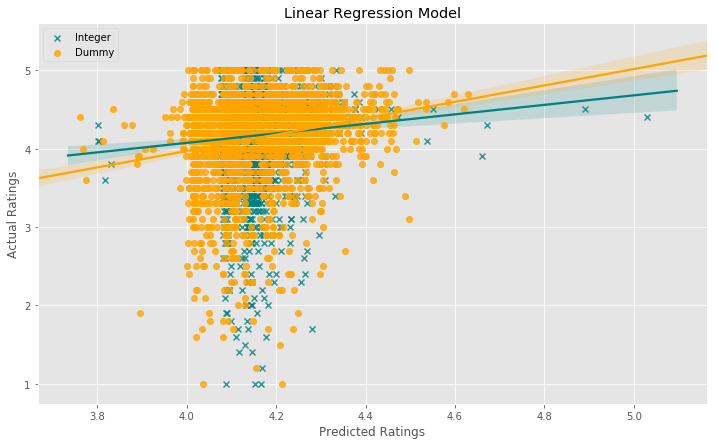

In [11]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x') 
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy') 
plt.legend()
plt.title('Linear Regression Model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [12]:
from sklearn import svm #Integer encoding
X = df.drop(labels = ['Category','Rating','Genres','Category_Integer'],axis = 1) 
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 
modelSVR = svm.SVR()
modelSVR.fit(X_train,y_train)
ResultsSVR = modelSVR.predict(X_test)
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test,ResultsSVR, name = 'SVM - Integer'),ignore_index = True)
#dummy based
X_d = df_Genres_dummy.drop(labels = ['Rating','Category','Category_Integer','Genres_Integer'],axis = 1) 
y_d = df_Genres_dummy.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
modelSVR = svm.SVR()
modelSVR.fit(X_train_d,y_train_d)
ResultsSVR_d = modelSVR.predict(X_test_d)
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test_d,ResultsSVR_d, name = 'SVM - Dummy'),ignore_index = True)

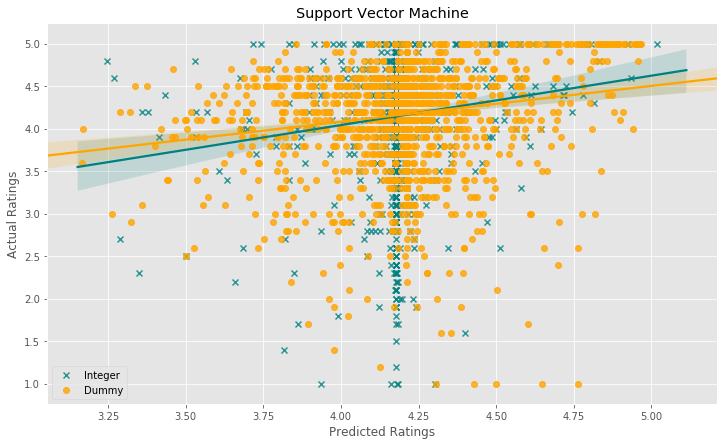

In [13]:
plt.figure(figsize=(12,7))
sns.regplot(ResultsSVR,y_test,color='teal', label = 'Integer', marker = 'x') 
sns.regplot(ResultsSVR_d,y_test_d,color='orange',label = 'Dummy') 
plt.legend()
plt.title('Support Vector Machine')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [14]:
from sklearn.ensemble import RandomForestRegressor
#Integer encoding
X = df.drop(labels = ['Category','Rating','Genres','Category_Integer'],axis = 1)
y = df.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
modelRandomForest = RandomForestRegressor()
modelRandomForest.fit(X_train,y_train)
ResultsRandomForest = modelRandomForest.predict(X_test)
#evaluation
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test,ResultsRandomForest, name = 'RFR - Integer'),ignore_index = True)
#dummy encoding
X_d = df_Genres_dummy.drop(labels = ['Rating','Category','Category_Integer','Genres_Integer'],axis = 1) 
y_d = df_Genres_dummy.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30) 
modelRandomForest_d = RandomForestRegressor() 
modelRandomForest_d.fit(X_train_d,y_train_d)
ResultsRandomForest_d = modelRandomForest_d.predict(X_test_d)
#evaluation
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test,ResultsRandomForest_d, name = 'RFR - Dummy'),ignore_index = True)

In [15]:
modelRandomForest.feature_importances_

array([0.33500037, 0.28096993, 0.12174519, 0.00653539, 0.02528728,
       0.02936681, 0.20109503])

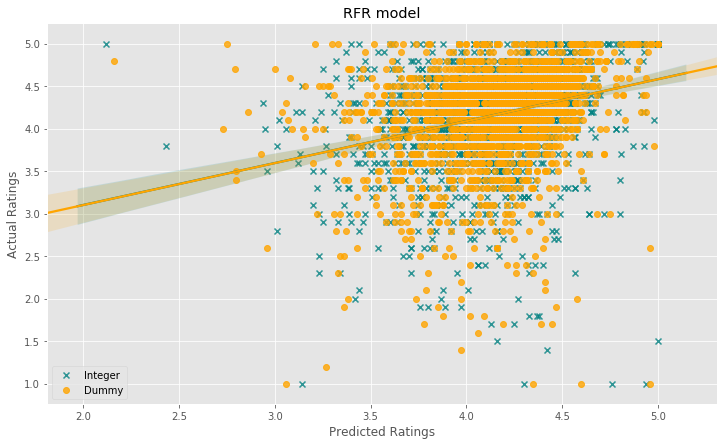

In [16]:
plt.figure(figsize=(12,7))
sns.regplot(ResultsRandomForest,y_test,color='teal', label = 'Integer', marker = 'x') 
sns.regplot(ResultsRandomForest_d,y_test_d,color='orange',label = 'Dummy') 
plt.legend()
plt.title('RFR model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

<Figure size 1008x720 with 0 Axes>

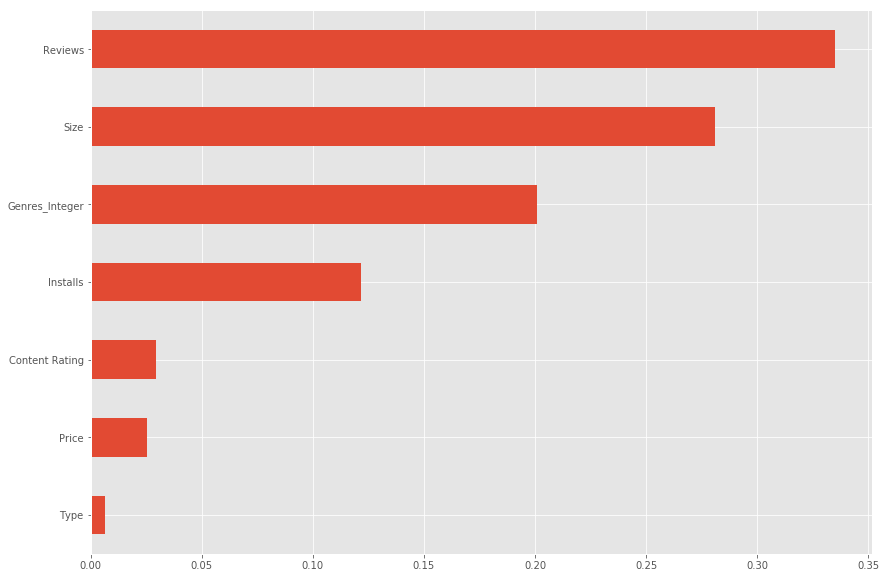

In [17]:
FeatureImportance = {}
for col,feat in zip(X.columns,modelRandomForest.feature_importances_):
    FeatureImportance[col] = feat
FeatureImportance_df = pd.DataFrame.from_dict(FeatureImportance,orient = 'index') 
FeatureImportance_df.sort_values(by = 0, inplace = True)
plt.figure(figsize= (14,10))
FeatureImportance_df.plot(kind = 'barh',figsize= (14,10),legend = False) 
plt.show()

<Figure size 1008x720 with 0 Axes>

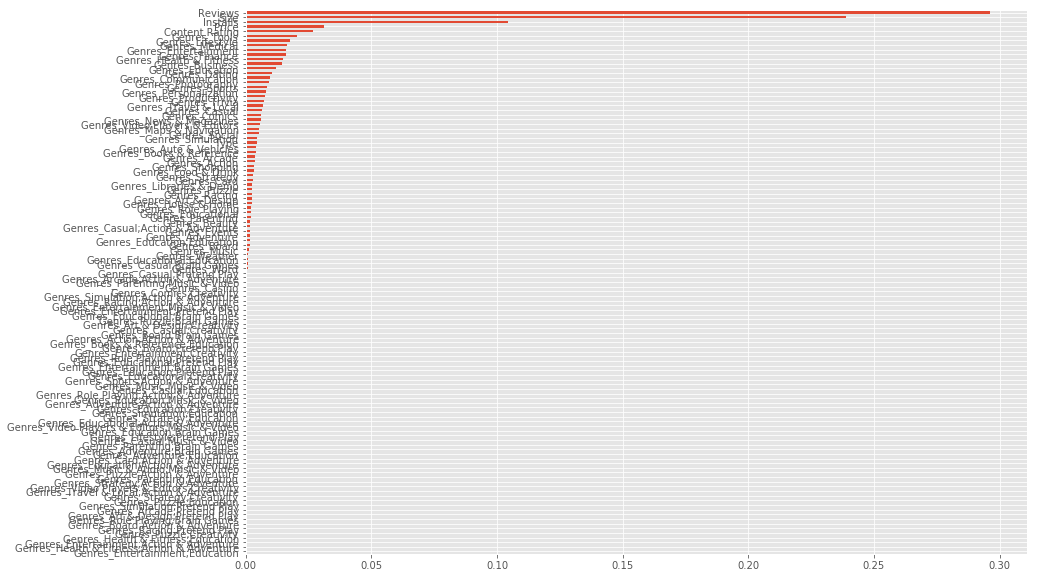

In [18]:
FeatureImportance_d = {}
for col,feat in zip(X_d.columns,modelRandomForest_d.feature_importances_):
    FeatureImportance_d[col] = feat
FeatureImportance_d_df = pd.DataFrame.from_dict(FeatureImportance_d,orient = 'index') 
FeatureImportance_d_df.sort_values(by = 0, inplace = True)
plt.figure(figsize= (14,10))
FeatureImportance_d_df.plot(kind = 'barh',figsize= (14,10),legend = False) 
plt.show()

In [19]:
Resultsdf

,Name,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogError
0,LinearRegression,0.306473,0.395127,0.0152027
1,LinearRegression - GenresDummy,0.313766,0.398441,0.0155511
2,SVM - Integer,0.338078,0.410312,0.0172013
3,SVM - Dummy,0.316628,0.389133,0.0158447
4,RFR - Integer,0.307576,0.380913,0.0151052
5,RFR - Dummy,0.401719,0.46799,0.0187719


In [20]:
df1=pd.read_csv('./机器学习2.csv')
df1

,结果,计算得分参考,FAC1_1,FAC2_1,FAC3_1
0,通过,84.669933,0.196594,0.433442,0.776502
1,通过,82.586879,0.196594,0.433442,0.776502
2,参拍,80.853072,0.219103,0.256527,-0.118380
3,参拍,80.622704,0.219103,0.256527,-0.118380
4,参拍,81.484362,0.219103,0.256527,-0.118380
5,通过,80.481910,0.196594,0.433442,0.776502
6,通过,72.407590,-2.878079,-2.697953,-0.249072
7,通过,76.101067,-1.434896,0.610357,-0.069666
8,参拍,75.562539,-1.434896,0.610357,-0.069666
9,通过,77.840030,-1.814631,0.433442,-1.399810


In [21]:
from sklearn.ensemble import RandomForestRegressor
#Integer encoding
X = df1.drop(labels = ['结果','计算得分参考'],axis = 1)
y = df1['计算得分参考']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
modelRandomForest = RandomForestRegressor()
modelRandomForest.fit(X_train,y_train)
ResultsRandomForest = modelRandomForest.predict(X_test)
#evaluation
Resultsdf = Resultsdf.append(CreateErrorEvaluationDict(y_test,ResultsRandomForest, name = 'RFR '),ignore_index = True)

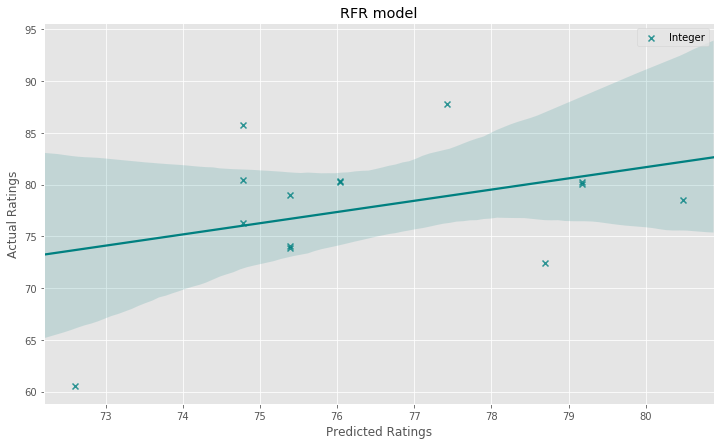

In [22]:
plt.figure(figsize=(12,7))
sns.regplot(ResultsRandomForest,y_test,color='teal', label = 'Integer', marker = 'x') 
plt.legend()
plt.title('RFR model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

<Figure size 1008x720 with 0 Axes>

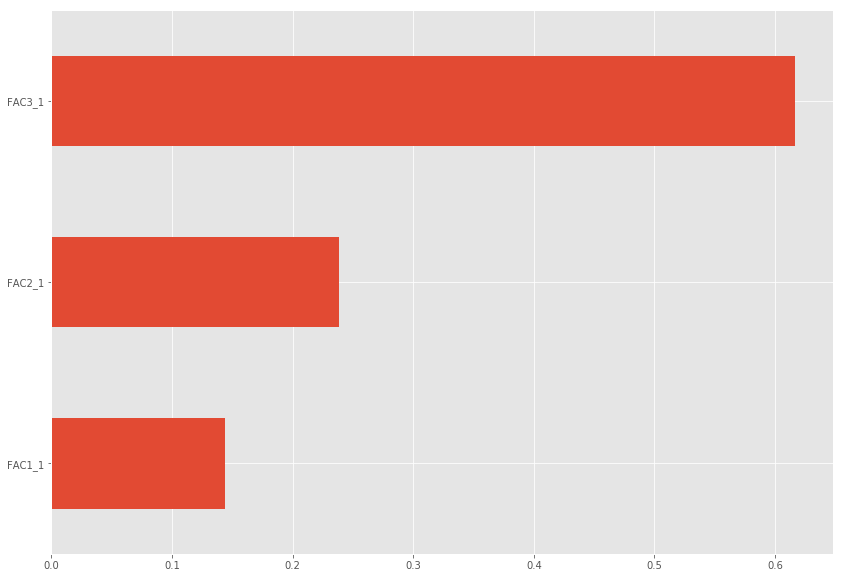

In [23]:
FeatureImportance = {}
for col,feat in zip(X.columns,modelRandomForest.feature_importances_):
    FeatureImportance[col] = feat
FeatureImportance_df = pd.DataFrame.from_dict(FeatureImportance,orient = 'index') 
FeatureImportance_df.sort_values(by = 0, inplace = True)
plt.figure(figsize= (14,10))
FeatureImportance_df.plot(kind = 'barh',figsize= (14,10),legend = False) 
plt.show()

In [24]:
modelRandomForest.feature_importances_

array([0.14416733, 0.23884328, 0.61698939])

In [25]:
Resultsdf

,Name,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogError
0,LinearRegression,0.306473,0.395127,0.0152027
1,LinearRegression - GenresDummy,0.313766,0.398441,0.0155511
2,SVM - Integer,0.338078,0.410312,0.0172013
3,SVM - Dummy,0.316628,0.389133,0.0158447
4,RFR - Integer,0.307576,0.380913,0.0151052
5,RFR - Dummy,0.401719,0.46799,0.0187719
6,RFR - Integer,36.1653,4.68441,0.00626309


In [26]:
resultsdf=CreateErrorEvaluationDict(y_test,ResultsRandomForest, name = 'RFR ')
resultsdf

{'Name': 'RFR ',
 'MeanSquaredError': 36.16534347433053,
 'MeanAbsoluteError': 4.684411183051219,
 'MeanSquaredLogError': 0.0062630855612698325}